In [ ]:
!pip install split-folders

In [ ]:
import cv2 as cv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import keras
from tensorflow import keras
from keras.utils import to_categorical
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from PIL import Image
import PIL
import torch.nn as nn
import torch.optim as optim
import splitfolders
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
splitfolders.ratio("/content/drive/MyDrive/Hear the Sign/Dataset/Images",output="/content/drive/MyDrive/Hear the Sign/Dataset/working/",seed=1337,ratio=(.8,.1,.1),group_prefix=None)

Copying files: 10873 files [04:33, 39.82 files/s]


In [ ]:
preprocess = transforms.Compose([
    transforms.Resize((256,256),PIL.Image.BILINEAR),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
Train_dataset = datasets.ImageFolder('/content/drive/MyDrive/Hear the Sign/Dataset/working/train', transform=preprocess)
Test_dataset = datasets.ImageFolder('/content/drive/MyDrive/Hear the Sign/Dataset/working/test', transform=preprocess)

In [ ]:
train_loader = DataLoader(Train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(Test_dataset,batch_size=32,shuffle=False)

In [ ]:
Model = models.resnet18(pretrained=True)
num_class = len(Train_dataset.classes)
Model.fc = nn.Linear(Model.fc.in_features, num_class)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


**Code for dual GPU usage**

In [ ]:
if torch.cuda.device_count() > 1:
    Model = nn.DataParallel(Model)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Model = Model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(Model.parameters(), lr=0.001)

In [ ]:
epochs = 5
for epoch in range(epochs):
    Model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = Model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.1463
Epoch 2, Loss: 0.1087
Epoch 3, Loss: 0.1107
Epoch 4, Loss: 0.1105
Epoch 5, Loss: 0.0279


# Model-Validation

In [ ]:
All_preds = []
All_Labels = []
Model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = Model(images)
        x, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        All_preds.extend(predicted.cpu().numpy())
        All_Labels.extend(labels.cpu().numpy())

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")

Test Accuracy: 94.87%


# Saving the Model

In [ ]:
torch.save(Model.state_dict(), '/content/drive/MyDrive/Hear the Sign/Main files/hear_the_sign-rebooted.pth')

# Creating Classification report and Confusion matrix

In [ ]:
target_names = [chr(i) for i in range(65, 91)]
print("Classification Report:\n")
print(classification_report(All_Labels, All_preds, target_names=target_names))

Classification Report:

              precision    recall  f1-score   support

           A       1.00      1.00      1.00        42
           B       0.95      0.98      0.97        43
           C       1.00      0.95      0.98        42
           D       0.98      0.95      0.96        42
           E       0.91      0.98      0.94        42
           F       0.95      0.95      0.95        42
           G       0.98      0.98      0.98        42
           H       0.91      1.00      0.96        43
           I       0.88      0.86      0.87        42
           J       0.82      0.98      0.89        42
           K       0.91      0.93      0.92        42
           L       0.95      0.98      0.96        42
           M       0.95      0.95      0.95        42
           N       0.98      0.93      0.95        43
           O       1.00      0.98      0.99        42
           P       1.00      0.88      0.94        43
           Q       0.95      1.00      0.97        38
   

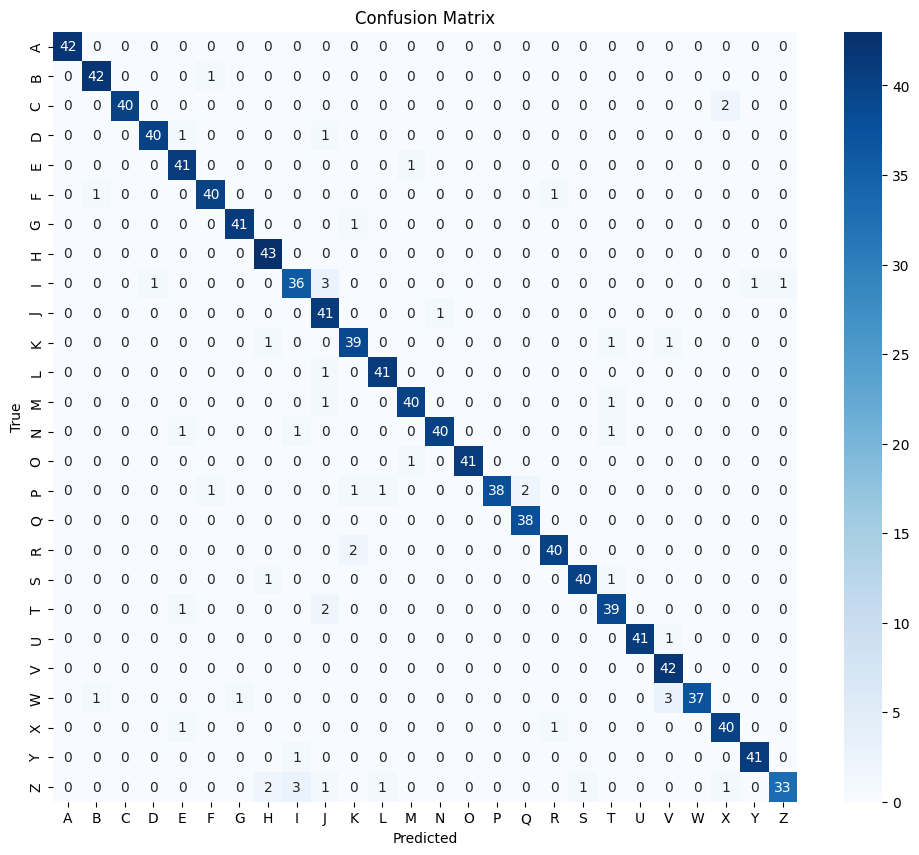

In [ ]:
cm = confusion_matrix(All_Labels, All_preds)
df_cm = pd.DataFrame(cm, index=target_names, columns=target_names)

plt.figure(figsize=(12, 10))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Failed Model

In [ ]:
Images = np.array(Images, dtype='float32') / 255.0
Labels = np.array(Labels)
Images = Images.reshape(-1, 255, 255, 1)

Y = to_categorical(Labels,num_classes=26)

print(Images.shape)

In [ ]:
Images = np.load("/content/drive/MyDrive/Hear the Sign/Dataset/Images.npy")
Labels = np.load("/content/drive/MyDrive/Hear the Sign/Dataset/Labels.npy")

In [ ]:
np.save('/content/drive/MyDrive/Hear the Sign/Dataset/Images.npy',Images)
np.save('/content/drive/MyDrive/Hear the Sign/Dataset/Labels.npy',Labels)

In [ ]:
def create_train():
  Labels = []
  Images = []
  DIR = '/kaggle/input/handsign-colored-1/Images'
  for folder in os.listdir(DIR):
    path = os.path.join(DIR,folder)
    for images in os.listdir(path):
      img_path = os.path.join(path,images)
      img = cv.imread(img_path)
      Images.append(img)
      Labels.append(ord(folder)-65)
  return Labels,Images

In [ ]:
train_img,test_img,train_label,test_label = train_test_split(Images,Y,random_state=45)

In [ ]:
print(train_img.shape)
print("Labels Shape:", train_label.shape)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
)

datagen.fit(train_img)

# Model Creation

In [ ]:
model = Sequential()

# 1st Conv Block
model.add(Conv2D(64, (3,3), activation='relu', input_shape=(255,255,1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

# 2nd Conv Block
model.add(Conv2D(128, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

# 3rd Conv Block
model.add(Conv2D(256, (3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

# Fully Connected Layers
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(26, activation='softmax'))  # 26 classes (A-Z)

To less accuracy Model is guessing

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])


In [ ]:
model.fit(datagen.flow(train_img,train_label,batch_size=32),validation_data=(test_img,test_label),epochs=30)

In [ ]:
test = test_img[50]

test = cv.resize(test,(255,255))
test= np.expand_dims(test,axis=-1)
test= np.expand_dims(test,axis=0)
print(test.shape)

res = model.predict(test)
print(res)

In [ ]:
plt.imshow(test_img[50],cmap='gray')

In [ ]:
predicted_class = np.argmax(res)
print(f"Predicted Class: {predicted_class}")

In [ ]:
import string
letters = list(string.ascii_uppercase)  # ['A', 'B', ..., 'Z']
print(f"Predicted Letter: {letters[predicted_class]}")

# Saving the Model

In [ ]:
import pickle
model_pkl_file = 'Hear_the_sign.pkl'
